In [44]:
from utils import dataloader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload  

import matplotlib.pyplot as plt

import numpy as np

import torch as th
import torch.nn as nn
import os
from datetime import datetime
import matplotlib as mpl
import torch.optim as optim
import pytorch_ssim

import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms

In [67]:
dataloader = reload(dataloader)

plotsize = 15

partitions = dataloader.DataPartitions(
    past_frames=8,
    future_frames=1,
    root="../datasets/arda/mini/",
    partial=0.01
)

dataset = dataloader.DataGenerator(
    root="../datasets/arda/mini/",
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 4),
    output_dim=(partitions.future_frames, 256, 256, 3),
    batch_size=4,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
    dynamicity = 1e-2
)

In [8]:
X, Y, extra_batch = dataset.get_data()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0


[x] 1 areas found
. . . . . . . . . . . . . . . . . . . . 
[100%] 20 valid sequences loaded


In [9]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [11]:
print("DEP min: {}\nVEL min: {}\nBTM min: {}".format(
    np.min(X_train[:, :, :, :, :, 0]),
    np.min(X_train[:, :, :, :, :, 1]),
    np.min(X_train[:, :, :, :, :, 2])
))

print("DEP max: {}\nVEL max: {}\nBTM max: {}".format(
    np.max(X_train[:, :, :, :, :, 0]),
    np.max(X_train[:, :, :, :, :, 1]),
    np.max(X_train[:, :, :, :, :, 2])
))

DEP min: 0.0
VEL min: -3.0152
BTM min: -0.691004
DEP max: 4.32622
VEL max: 4.80414
BTM max: 6.84653


### Model

In [12]:
import torch.nn.functional as F
from functools import partial


In [13]:
if th.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = th.device(dev)

print(device)

cpu


In [14]:
from models.ae import ConvLSTMCell

from models.ae import seq2seq_ConvLSTM
seq2seq_ConvLSTM = reload(seq2seq_ConvLSTM)

net = seq2seq_ConvLSTM.EncoderDecoderConvLSTM(nf=4, in_chan=4).to(device) # False: many to one

In [17]:
weights_path = "../trained_models/train_45_10_08_2021_19_28_41/model.weights"
net.load_state_dict(th.load(weights_path, map_location=th.device('cpu')))

<All keys matched successfully>

In [18]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [19]:
# b, s, t, h, w, c -> b, s, t, c, h, w
X_train = X_train.permute(0, 1, 2, 5, 3, 4)
y_train = y_train.permute(0, 1, 2, 5, 3, 4)

In [20]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [21]:
# b, s, t, h, w, c -> b, s, t, c, h, w
X_test = X_test.permute(0, 1, 2, 5, 3, 4)
y_test = y_test.permute(0, 1, 2, 5, 3, 4)

torch.Size([4, 4, 8, 4, 256, 256])


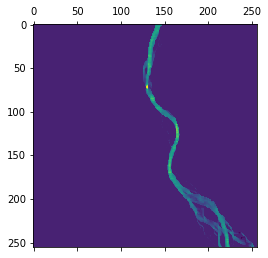

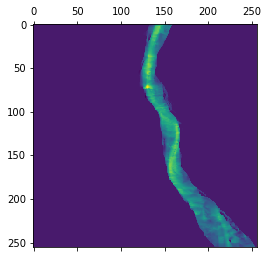

In [24]:
plt.matshow(X_train[2,2,0,2,:,:])
plt.matshow(y_train[2,2,0,2,:,:])
print(X_train.shape)

In [ ]:
# Valid sequences
for i, batch in enumerate(X_train):
    for j, sequence in enumerate(batch):

        # first three channels (dep, vvx, vvy): x/y aligned
        #sequence = np.concatenate((sequence[:,:3,:,:], y_train[i,j,:,0,:,:].unsqueeze(0)), axis=0)

        fig, axs = plt.subplots(1, sequence.shape[0], figsize=(plotsize,plotsize))

        for ax in axs:
            ax.set_yticklabels([])
            ax.set_xticklabels([])

        for k,frame in enumerate(sequence):   # x frames
            axs[k].matshow(frame[0])

In [27]:
losses = []
errors = []
test_errors = []
criterion = nn.MSELoss(reduction='sum')

### Sequence mode


In [ ]:

tests = 1

for test in range(tests):  # loop over the dataset multiple times

    k = np.random.randint(len(X_train))

    _, last_states = net(X_train[k])
    outputs = last_states[0][-1]  # 0 for layer index, 0 for h index

    test_loss = criterion(outputs[0],  y_train[k,:,:,0,:,:])
    #print("test loss: {}".format(test_loss.item()))

    #------------------------------
    fig, axs = plt.subplots(1, X_train.shape[2] + 3, figsize=(plotsize,plotsize))

    for ax in axs:
        ax.set_yticklabels([])
        ax.set_xticklabels([])

    # pick random datapoint from batch
    x = np.random.randint(X_train[k].shape[0])

    for i,frame in enumerate(X_train[k,x]):
        axs[i].matshow(frame[0].cpu().detach().numpy())

    axs[i+1].matshow(outputs[x][0].cpu().detach().numpy())
    axs[i+2].matshow(outputs[x][1].cpu().detach().numpy())
    axs[i+3].matshow(outputs[x][2].cpu().detach().numpy())

    plt.show()

print('Finished Training')

### Autoregressive

In [29]:

tests = 1

k = np.random.randint(len(X_train))
input = X_train[k]

for test in range(tests):  # loop over the dataset multiple times

    outputs = net(input, 1)    
    test_loss = criterion(outputs[:,0,:,:], y_train[k,:,0,0,:,:])
    #print("test loss: {}".format(test_loss.item()))
    
    # b, t, c, h, w
    next_input = th.empty(input.shape)
    next_input[:, :3, 0, :, :]
    print(outputs.shape)
    break

    #------------------------------
    fig, axs = plt.subplots(1, X_train.shape[2] + 3, figsize=(plotsize,plotsize))

    for ax in axs:
        ax.set_yticklabels([])
        ax.set_xticklabels([])

    # pick random datapoint from batch
    x = np.random.randint(X_train[k].shape[0])

    for i,frame in enumerate(X_train[k,x]):
        axs[i].matshow(frame[0].cpu().detach().numpy())

    axs[i+1].matshow(outputs[x][0].cpu().detach().numpy())
    axs[i+2].matshow(outputs[x][1].cpu().detach().numpy())
    axs[i+3].matshow(outputs[x][2].cpu().detach().numpy())

    plt.show()

print('Finished Training')

torch.Size([4, 1, 1, 256, 256])
Finished Training


/Users/diegocalanzone/anaconda3/envs/tfdeeplearning/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([4, 256, 256])) that is different to the input size (torch.Size([4, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
'''
num_run = len(os.listdir("runs/")) + 1
now = datetime.now()
foldername = "train_{}_{}".format(num_run, now.strftime("%d_%m_%Y_%H_%M_%S"))
os.mkdir("runs/" + foldername)

weights_path = "runs/" + foldername + "/model.weights"
th.save(net.state_dict(), weights_path)
'''

In [ ]:
mpl.rcParams['text.color'] = 'k'

plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

In [ ]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass


In [ ]:
mpl.rcParams['text.color'] = 'w'
prep = Preprocessing()

In [ ]:
j = np.random.randint(len(y_test))
j = 3
m = 2
k = 4

print("k = {}".format(k))

#k = 5
input = th.unsqueeze(X_test[j, m], 0)
outputs = net(input)

#------------------------------
num_predicted_frames = outputs[0, 0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    frame = frame.cpu().detach().numpy()
    axs[i].matshow(frame)
    axs[i].set_title('t = {}'.format(i))

print("======== Past frames ========")
plt.show()

print("======== True Future vs Predicted frames ========")

#------------------------------
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_test[j,m,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))

plt.show()
#------------------------------
fig, axs = plt.subplots(1, outputs[0,0].shape[0], figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(outputs[0,0]):
    attention_mask = outputs[0,1,i].cpu().detach().numpy()
    y_frame = frame.cpu().detach().numpy()
    y_true = y_test[j,m,0,i].cpu().detach().numpy()

    y_frame = np.dot(y_frame, attention_mask)
    y_true = np.dot(y_true, attention_mask)

    print(y_frame[:5,:5])
    print("#-------------")
    print(y_true[:5,:5])
    print("\n\n")

    ssim = prep.pytorch_ssim(y_true, y_frame).item()
    axs[i].matshow(y_frame)
    axs[i].set_title('ssim = {}'.format(ssim))

plt.show()
#------------------------------

In [ ]:
print("k = {}".format(k))
iterations = 4
#k = 5

input = th.unsqueeze(X_train[k,0], 0)
outputs = net(input)

#------------------------------
print("======== Past frames ========")
num_predicted_frames = outputs[0,0].shape[0] # per allineare frames passati e futuri
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(input[0,0,-num_predicted_frames:]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i))

plt.show()
#------------------------------
print("======== True vs Autoregressive Pred Frames  ========")
fig, axs = plt.subplots(1, num_predicted_frames, figsize=(plotsize,plotsize))

true_means = []

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

for i,frame in enumerate(y_train[k,0,0]):
    axs[i].matshow(frame.cpu().detach().numpy())
    axs[i].set_title('t = {}'.format(i+num_predicted_frames))
    true_means.append(frame.cpu().detach().numpy().mean())

plt.show()
#------------------------------

#i = np.random.randint(len(X_test))
input = th.unsqueeze(X_train[k][0], 0)

fig, axs = plt.subplots(1, iterations, figsize=(plotsize,plotsize))

for ax in axs:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

predicted_means = []
for x in range(iterations):
    # first predicted frame only
    output = th.unsqueeze(net(input)[:,:,0,:,:],2)
    # next frame = first predicted from output + btm map
    next_frame = output.detach()
    next_frame = th.cat((next_frame, th.unsqueeze(input[:,2:,0,:,:],2)), axis=1)
    # added on top of (input sequence - first frame)
    input = th.cat((next_frame, input[:,:,1:,:]), axis=2)

    axs[x].matshow(output[0,0,0].cpu().detach().numpy())
    axs[x].set_title('t = {}'.format(x+num_predicted_frames))
    predicted_means.append(output[0,0,0].cpu().detach().numpy().mean())
    #print(np.mean(output[0,0,0].cpu().detach().numpy()))

plt.show()

In [ ]:
mpl.rcParams['text.color'] = 'b'

plt.clf()
plt.plot(range(len(true_means)), true_means,  "-b", label="True frames mean")
plt.plot(range(len(true_means)), true_means,  "*")

plt.plot(range(len(predicted_means)), predicted_means,  "-g", label="Predicted frames mean")
plt.plot(range(len(predicted_means)), predicted_means,  "*")
plt.grid()
plt.legend()
pass

In [ ]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))